**Prototype for Importing Jhe-Lab Approach Curve Data**

We will define helper functions that imports resonance curve and approach curve data

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def ImportResCurve(filepath, visualize = False, fit_param_init = [5000, 3, 1/800]):
    '''
    <ImportResCurve>
    
    Inputs: filepath 
        filepath - filepath of the resonance curve file
    
    Outputs: res_data, fit_param, w
        res_data - resonance curve data in pandas dataframe format
        fit_param - resonance curve fitting parameters, [w0, Q, I0, C0/C]
        w - driving frequency (assumes that the driving frequency is the frequency at which the resonance curve takes its maximum)
    '''
    
    # Define the resonance curve function as an inner function
    def _ResCurve(w, w0, Q, I_0, C0_C):
        W = w/w0
        return (I_0*W/Q)*np.sqrt(np.divide(1+2*C0_C*(1-W**2)+(C0_C*(1-W**2))**2+(C0_C*W/Q)**2, (1-W**2)**2+(W/Q)**2))
    
    # Import resonance curve data using pandas
    # The parameter skiprows ensures that the comments on the top 
    res_data = pd.read_csv(filepath, header = None, delimiter = '\t', skiprows = 9)
    
    # Res curve is in the format [freq, amp, freq, phas, aux], so drop the redundant 3rd column
    res_data = res_data.drop(res_data.columns[4], axis = 1)
    res_data = res_data.drop(res_data.columns[2], axis = 1)
    
    # Set appropriate column name
    res_data.rename(columns = {0:'Frequency(Hz)', 1:'Amplitude(V)', 3:'Phase(V)'}, inplace = True)
    
    # Numpy array of the resonance curve data in [freq, amp, phas] format
    res_array = res_data.values
    
    # Frequency of  the maximum amplitude measured. This is equal the driving frequency used
    w0_init = res_array[res_array[:,1].argmax(),0] 
    w = w0_init
    
    # Fit the resonance curve
    Q_init, I0_init, C0_C_init = fit_param_init
    fit_param, _ = curve_fit(_ResCurve, res_array[:,0], res_array[:,1], p0 = [w0_init, Q_init, I0_init, C0_C_init], bounds = (0, np.inf))
    
    if visualize:
        # For the visualize keyword, create a figure of the experimental and fitted resonance curve
        fontsize = 13
        labelpad = 10
        tkw = dict(size = 6, width = 1.5, labelsize = fontsize)
        
        fig, ax_left = plt.subplots(1, 1, figsize = (7,5))
        ax_left.plot(res_array[:,0], res_array[:,1], '.-k', label = 'Amplitude(V)')
        ax_left.plot(res_array[:,0], _ResCurve(res_array[:,0], *fit_param), '-r', alpha = 0.8, label = 'Fitted Curve')
        ax_left.set_xlabel('Frequency (Hz)', fontsize = fontsize, labelpad = labelpad)
        ax_left.set_ylabel('Amplitude (V)', fontsize = fontsize, labelpad = labelpad)
        
        ax_right = ax_left.twinx()
        ax_right.plot(res_array[:,0], res_array[:,2], '.-b', alpha = 0.2, label = 'Phase(V)')
        ax_right.set_ylabel('Phase(V)', fontsize = fontsize, labelpad = labelpad)
        ax_left.grid(ls = '--')
        
        h_right, l_right = ax_right.get_legend_handles_labels()
        h_left, l_left = ax_left.get_legend_handles_labels()
        
        ax_left.tick_params(axis='x', **tkw)
        ax_left.tick_params(axis='y', **tkw)
        ax_right.tick_params(axis='y', colors='blue', **tkw)
        ax_right.yaxis.label.set_color('blue')
            
        ax_right.legend(h_right+h_left, l_right+l_left, loc = 'upper right', fontsize = fontsize - 1)
        
    return res_data, fit_param, w

    

In [2]:
import pandas as pd
filepath = '../../Raw Data/Tapping_Mode/Dohyun_best/try1_32737_6/2res.txt'

(     Frequency(Hz)  Amplitude(V)  Phase(V)
 0          32637.6      0.276367  1.542854
 1          32638.1      0.316040  1.522508
 2          32638.6      0.297638  1.459455
 3          32639.1      0.285675  1.495301
 4          32639.6      0.305573  1.424205
 5          32640.1      0.261383  1.420594
 6          32640.6      0.284454  1.698809
 7          32641.1      0.309814  1.342180
 8          32641.6      0.270386  1.582738
 9          32642.1      0.344269  1.605290
 10         32642.6      0.328094  1.658915
 11         32643.1      0.311859  1.563169
 12         32643.6      0.339661  1.362367
 13         32644.1      0.316528  1.563627
 14         32644.6      0.335785  1.445926
 15         32645.1      0.270477  1.413308
 16         32645.6      0.296021  1.449559
 17         32646.1      0.342896  1.431609
 18         32646.6      0.319031  1.456685
 19         32647.1      0.342804  1.508212
 20         32647.6      0.344452  1.541853
 21         32648.1      0.36566

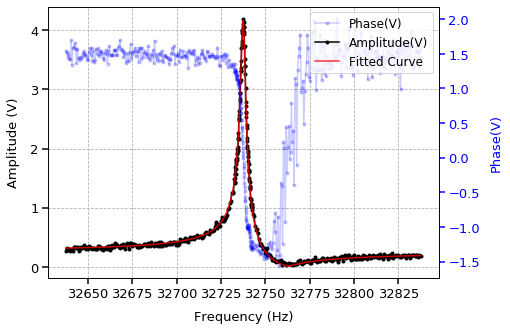

In [3]:
ResCurve_Importer(filepath, visualize = True)

In [41]:
def ImportAppCurve(filepath, visualize = False):
    data = pd.read_csv(filepath, header = None, delimiter = '\t', engine = 'python', skipfooter = 20) # Skip all the comments at the bottom
    data = data.drop(data.columns[3], axis=1) # Drop the Aux1 measurements
    data.rename(columns = {0:'z(nm or bits)', 1:'Amplitude(V)', 2:'Phase(V)'}, inplace = True)

    imin = data.idxmin(axis = 0)[0]
    
    if visualize:
        # For the visualize keyword, create a figure of the experimental and fitted resonance curve
        fontsize = 13
        labelpad = 10
        tkw = dict(size = 6, width = 1.5, labelsize = fontsize)
        
        fig, ax_left = plt.subplots(1, 1, figsize = (7,5))
        ax_left.plot(data.iloc[0:imin+1,0], data.iloc[0:imin+1,1], '.-k', alpha = 0.8, label = 'Amplitude_Approach(V)')
        ax_left.plot(data.iloc[imin+1:,0], data.iloc[imin+1:,1], '.-b', alpha = 0.8, label = 'Amplitude_Retract(V)')
        ax_left.set_xlabel('Frequency (Hz)', fontsize = fontsize, labelpad = labelpad)
        ax_left.set_ylabel('Amplitude (V)', fontsize = fontsize, labelpad = labelpad)
        
        ax_right = ax_left.twinx()
        ax_right.plot(data.iloc[0:imin+1,0], data.iloc[0:imin+1,2], '.-r', alpha = 0.8, label = 'Phase_Approach(V)')
        ax_right.plot(data.iloc[imin+1:,0], data.iloc[imin+1:,2], '.-m', alpha = 0.8, label = 'Phase_Retract(V)')
        ax_right.set_ylabel('Phase(V)', fontsize = fontsize, labelpad = labelpad)
        ax_left.grid(ls = '--')
        
        h_right, l_right = ax_right.get_legend_handles_labels()
        h_left, l_left = ax_left.get_legend_handles_labels()
        
        ax_left.tick_params(axis='x', **tkw)
        ax_left.tick_params(axis='y', **tkw)
        ax_right.tick_params(axis='y', colors='red', **tkw)
        ax_right.yaxis.label.set_color('red')
            
        ax_right.legend(h_right+h_left, l_right+l_left, loc = 'upper right', fontsize = fontsize - 1)
        
    return data, imin

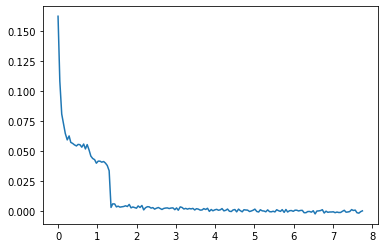

In [32]:
filepath = '../../Raw Data/Shear_Mode/Dohyun_best/180119_RH10/_17.txt'
data = pd.read_csv(filepath, header = None, delimiter = '\t', engine = 'python', skipfooter = 20) # Skip all the comments at the bottom
data = data.drop(data.columns[3], axis=1) # Drop the Aux1 measurements
data.rename(columns = {0:'z(nm or bits)', 1:'Amplitude(V)', 2:'Phase(V)'}, inplace = True)
data.iloc[:, 2] = data.iloc[:, 2] - data.iloc[0, 2]
imin = data.idxmin(axis = 0)[0]

app_data = data.iloc[0:imin+1, :]
ret_data = data.iloc[imin+1:, :]

plt.plot(app_data.iloc[:,0], app_data.iloc[:,2])

(     z(nm or bits)  Amplitude(V)  Phase(V)
 0         7.751747      7.211548  0.003973
 1         7.708241      7.197815  0.003313
 2         7.661563      7.216400  0.002056
 3         7.613072      7.210419  0.002429
 4         7.569113      7.210419  0.004591
 5         7.518356      7.210602  0.004304
 6         7.477570      7.203156  0.005039
 7         7.427719      7.208588  0.003388
 8         7.383760      7.202667  0.003047
 9         7.335269      7.195923  0.002866
 10        7.289951      7.219452  0.004463
 11        7.241913      7.200684  0.003590
 12        7.196141      7.211334  0.002631
 13        7.148557      7.206512  0.002599
 14        7.103238      7.207642  0.002983
 15        7.055653      7.205750  0.002439
 16        7.010335      7.218384  0.003206
 17        6.967282      7.210358  0.003036
 18        6.918338      7.206665  0.003036
 19        6.870753      7.203003  0.002759
 20        6.824982      7.205475  0.003707
 21        6.778757      7.20947

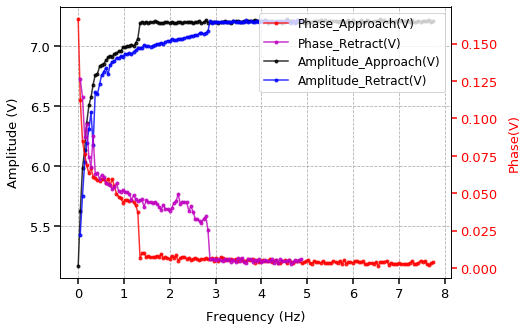

In [42]:
filepath = '../../Raw Data/Shear_Mode/Dohyun_best/180119_RH10/_17.txt'
ImportAppCurve(filepath, visualize = True)

In [ ]:
filepath = '../../Raw Data/Tapping_Mode/Dohyun_best/try1_32737_6/3.txt'

In [26]:
app_data.tail()

,z(nm or bits),Amplitude(V),Phase(V)
1976,0.182634,3.035919,0.275222
1977,0.136409,2.830811,0.221873
1978,0.092450,2.705811,0.178613
1979,0.047131,2.257019,0.565059
1980,0.000000,1.768311,0.738324


In [20]:
imin = data.idxmin(axis = 0)[0]
print(imin)

1980
